# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pylab import rcParams
import seaborn as sns
from array import array
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
%matplotlib inline


# Useful functions

In [2]:
begins=[]
ends=[]
names =[]
with open ("CommonData/sequence.gb") as f:
    in_pep = False
    for l in f:
        if "mat_peptide" in l:
            begins.append(int(l.split()[1].split("..")[0]))
            ends.append(int(l.split()[1].split("..")[1]))
            in_pep = True
        elif in_pep :
            names.append(l.split("=")[1])
            in_pep = False
            
print(begins)
print(ends)
print(names)

[108, 474, 753, 978, 2490, 3546, 4224, 4614, 6465, 6846, 6915, 7668]
[473, 752, 977, 2489, 3545, 4223, 4613, 6464, 6845, 6914, 7667, 10376]
['"capsid"\n', '"propeptide"\n', '"membrane"\n', '"envelope"\n', '"NS1"\n', '"NS2A"\n', '"NS2B"\n', '"NS3"\n', '"NS4A"\n', '"2K"\n', '"NS4B"\n', '"NS5"\n']


In [3]:
# Interesting positions
positions=[316,1670,1785,2340,5935,7172,8449,9165]
def plot_positions():
    for x in positions:
        plt.axvline(x=x, linewidth=1, linestyle=':')
        
def plot_genes():
    for i in range(len(begins)):
        plt.plot([begins[i], begins[i]], [0.99,1.0], linewidth=2, linestyle='-', color="black")
        if i%2==0:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.005, (names[i].replace('"', ''))[0:3], size='xx-small')
        else:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.015, (names[i].replace('"', ''))[0:3], size='xx-small')
    plt.plot([ends[-1], ends[-1]], [0.99,1.0], linewidth=2, linestyle='-', color="black")



In [4]:
def synonymous (row):
    if row['null'] or (row['Consensus_aa']==row['Secondbase_aa'] ):
        return "synonymous" 
    else:
        return "non-synonymous"

def add_columns(table):
    table['null'] = (table['Secondbase_aa']).isnull()
    table['is_synonymous'] = table.apply (lambda row: synonymous (row),axis=1)
    table['1_major_variant_frequency'] = 1.0 - table['Major_variant_frequency_quality_corrected']

In [5]:
def is_increasing(minor_frequencies):
    #print(minor_frequencies)
    previous = minor_frequencies[0]
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m]:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True

def get_variant_frequency(variant, table, i):
    sum_of_bases = table['As_quality_corrected'][i]+table['Cs_quality_corrected'][i]+table['Gs_quality_corrected'][i]+table['Ts_quality_corrected'][i]+table['Ns_quality_corrected'][i]
    if variant == "A":
        return table["As_quality_corrected"][i] / sum_of_bases
    elif variant == "C":
        return table["Cs_quality_corrected"][i] / sum_of_bases
    elif variant == "G":
        return table["Gs_quality_corrected"][i] / sum_of_bases
    elif variant == "T":
        return table["Ts_quality_corrected"][i] / sum_of_bases
    else:
        return np.nan
        

def get_increasing_variants(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    increasingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        if major == last["Major_variant"][i]:
            minor = last["Second_variant"][i]
        else:
            minor = last["Major_variant"][i]
        minor_frequencies[0] = get_variant_frequency(minor, first, i)
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
            minor_frequencies[table_id] = get_variant_frequency(minor, tables[table_id], i)
        if is_increasing(minor_frequencies):
            increasingVariants[i] = [major_frequencies.tolist(), minor_frequencies.tolist()]
    return increasingVariants



# Reading the data

In [6]:
# Control runs, replicate A
DD3_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD3_A)
DD6_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD6_A)
DD9_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD9_A)
DD12_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD12_A)
DD18_A = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD18_A)
DD24_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD24_A)
DD51_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A)
DD51_A_no_reamp = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51Anoreamplification_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A_no_reamp)

tables_A = [DD3_A, DD6_A, DD9_A, DD12_A, DD18_A, DD24_A, DD51_A]


In [7]:
# Control runs, replicate D
DD3_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD3_D)
DD6_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD6_D)
DD9_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD9_D)
DD12_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD12_D)
DD18_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD18_D)
DD24_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD24_D)

tables_D = [DD3_D, DD6_D, DD9_D, DD12_D, DD18_D, DD24_D]


In [8]:
# Control runs, replicate E
DD3_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD3E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD6_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD9_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD12_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD12E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD18_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24crude_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24Ecrude_1_sequence.txt.assembled.fastq_mapped_AA.csv")

add_columns(DD3_E)
add_columns(DD6_E)
add_columns(DD9_E)
add_columns(DD12_E)
add_columns(DD18_E)
add_columns(DD24_E)
add_columns(DD24crude_E)

tables_E = [DD3_E, DD6_E, DD9_E, DD12_E, DD18_E, DD24_E]

In [9]:
# TLR3 activation runs, replicate A
TD9_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD9_A)
TD12_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD12_A)
TD18_A = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD18_A)
TD24_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD24_A)
TD51_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD51_A)

tables_TA = [TD9_A, TD12_A, TD18_A, TD24_A, TD51_A]

In [10]:
# TLR3 activation runs, replicate D
TD9_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD12_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD18_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD24_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")

add_columns(TD9_D)
add_columns(TD12_D)
add_columns(TD18_D)
add_columns(TD24_D)

tables_TD = [TD9_D, TD12_D, TD18_D, TD24_D]

In [11]:
# TLR3 activation runs, replicate E
TD9_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD12_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD12E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD18_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD24_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD24E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD9_E)
add_columns(TD12_E)
add_columns(TD18_E)
add_columns(TD24_E)

tables_TE = [TD9_E, TD12_E, TD18_E, TD24_E]

# Positions that increase in frequency in the different replicates and conditions

In [12]:
increasing_A = get_increasing_variants(tables_A)
print("There are "+str(len(increasing_A))+" positions that rise in frequency.")
print("Those are:")
print(increasing_A.keys())

There are 5 positions that rise in frequency.
Those are:
dict_keys([316, 1670, 1785, 8449, 8466])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


## Plotting only positions that consistently rise in frequency, control, replicate A

In [15]:
def plot_increasing_positions(increasing_pos, last_time_point) :
    sns.set_palette("hls")
    sns.set_context("poster")
    increasing_pos_keys = increasing_pos.keys()
    Is_increasing = []
    for i in last_time_point['Position']:
        if i in increasing_pos_keys:
            Is_increasing.append("Increasing")
        else:
            Is_increasing.append("Not increasing")
        
    to_plot = pd.DataFrame ({'Position':last_time_point['Position'], 'Major_variant_frequency_quality_corrected':last_time_point ['Major_variant_frequency_quality_corrected'],'Is_increasing':Is_increasing, 'is_synonymous':last_time_point ['is_synonymous']}) 
    ax=sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=to_plot, fit_reg=False, hue='Is_increasing', row='is_synonymous', legend=False, size=7, aspect=2)
    ax.set(xlabel='Position along the genome', ylabel='Major variant frequency, last time point')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plot_positions()


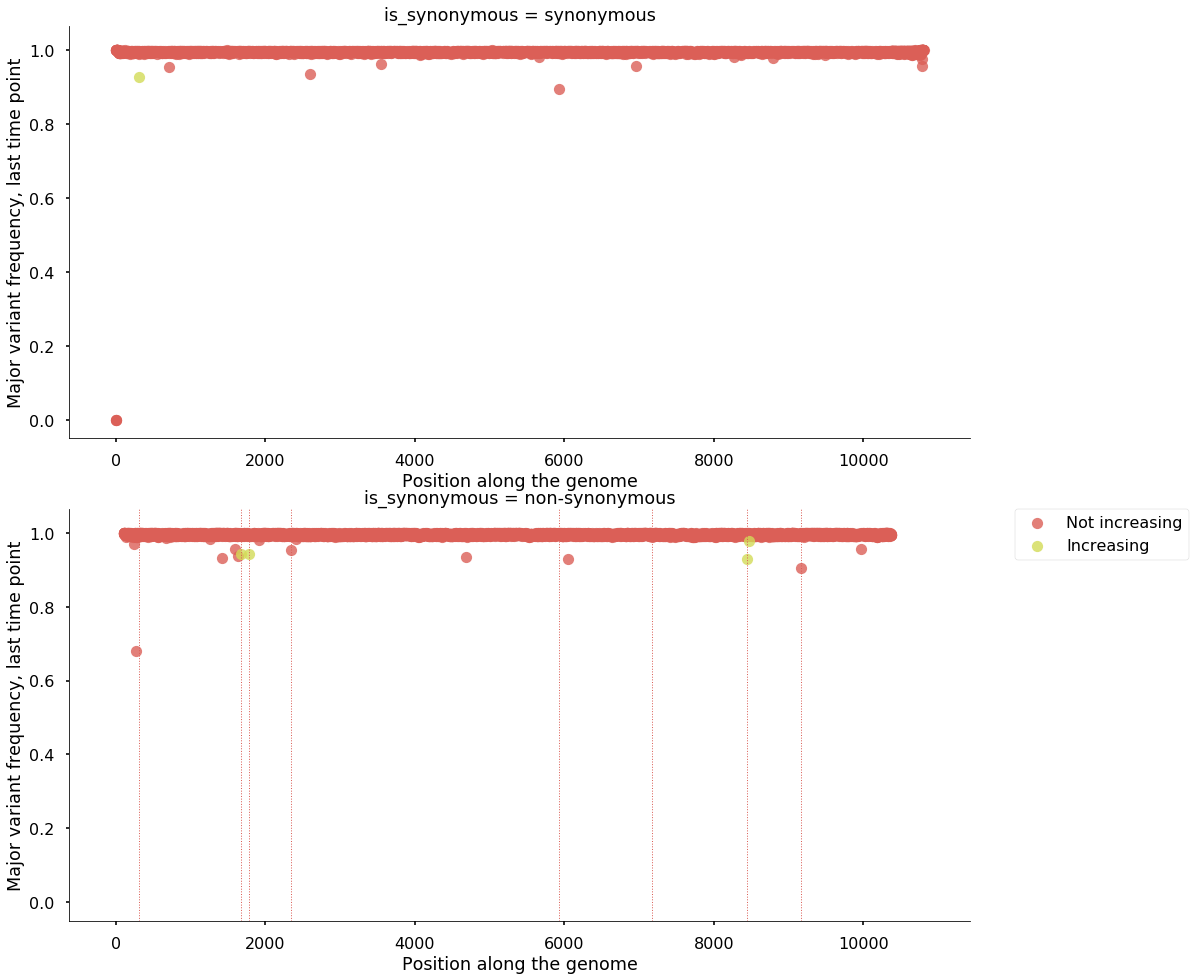

In [16]:
plot_increasing_positions(increasing_A, DD51_A)

## Write out the table

In [17]:
def write_increasing_positions(increasing_pos, tables, exp_names, filename) :
    increasing_pos_table = pd.DataFrame()

    for d in tables:
        increasing_pos_table = pd.concat([increasing_pos_table,d[d['Position'].isin(increasing_pos)]])

    num = len(increasing_pos)

    expnames_iterated = []
    for i in exp_names : 
        expnames_iterated.append([i]*num)

    expnames = [item for sublist in expnames_iterated for item in sublist]
    print(len(expnames))
    increasing_pos_table['expName']=expnames
    increasing_pos_table.to_csv( filename )


In [18]:
write_increasing_positions(increasing_A, tables_A, ["DD3_A", "DD6_A", "DD9_A", "DD12_A", "DD18_A", "DD24_A", "DD51_A"], "increasing_A.csv")



35


## Plotting only positions that consistently rise in frequency, control, replicate D

In [19]:
increasing_D = get_increasing_variants(tables_D)
print("There are "+str(len(increasing_D))+" positions that rise in frequency.")
print("Those are:")
print(increasing_D.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


There are 14 positions that rise in frequency.
Those are:
dict_keys([1916, 2069, 2200, 3397, 3523, 3883, 4606, 5812, 6286, 6558, 6634, 6893, 7172, 8472])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


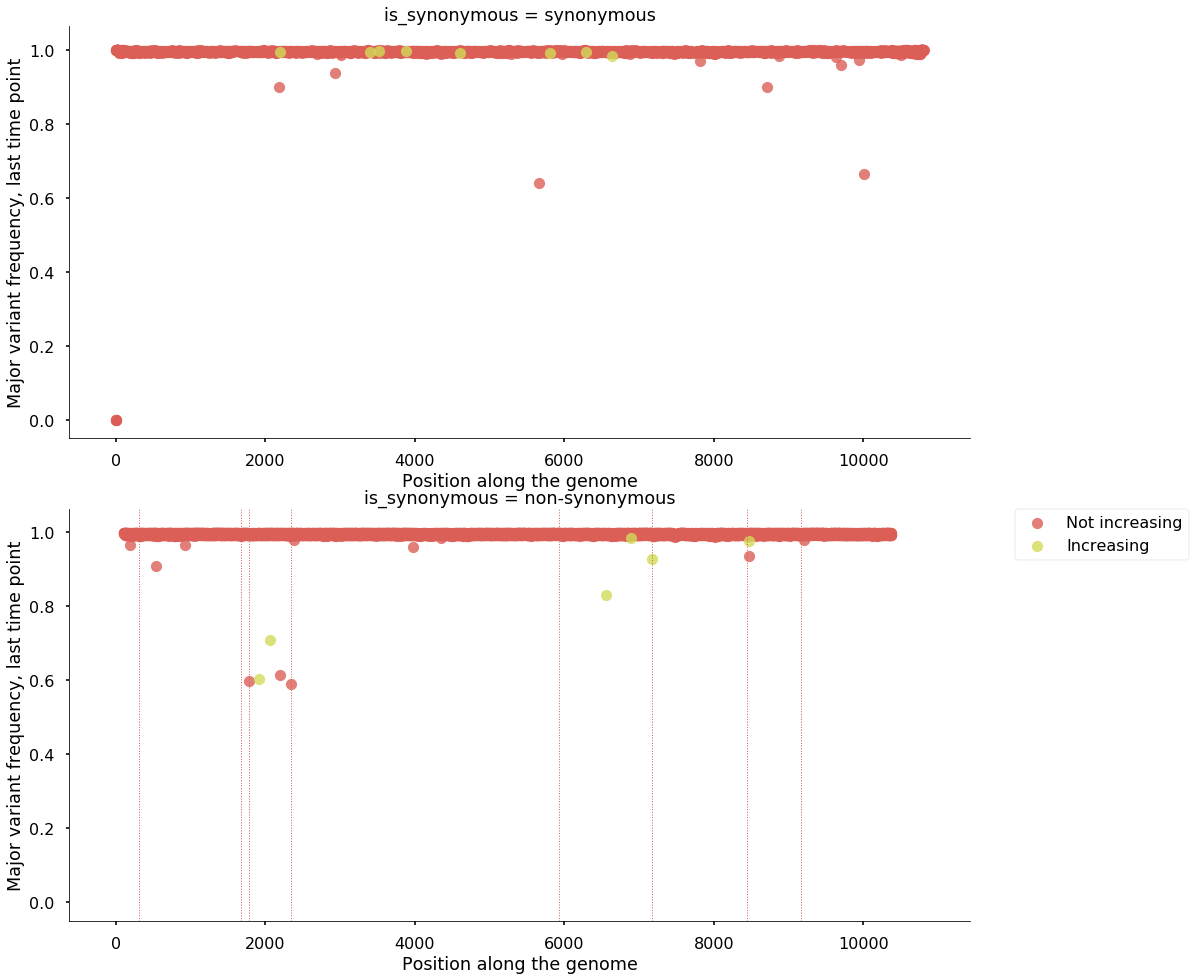

In [20]:
plot_increasing_positions(increasing_D, DD24_D)


In [21]:
write_increasing_positions(increasing_D, tables_D, ["DD3_D", "DD6_D", "DD9_D", "DD12_D", "DD18_D", "DD24_D"], "increasing_D.csv")


84


## Plotting only positions that consistently rise in frequency, control, replicate E

In [23]:
increasing_E = get_increasing_variants(tables_E)
print("There are "+str(len(increasing_E))+" positions that rise in frequency.")
print("Those are:")
print(increasing_E.keys())

There are 6 positions that rise in frequency.
Those are:
dict_keys([1670, 5171, 7078, 7172, 9721, 10394])


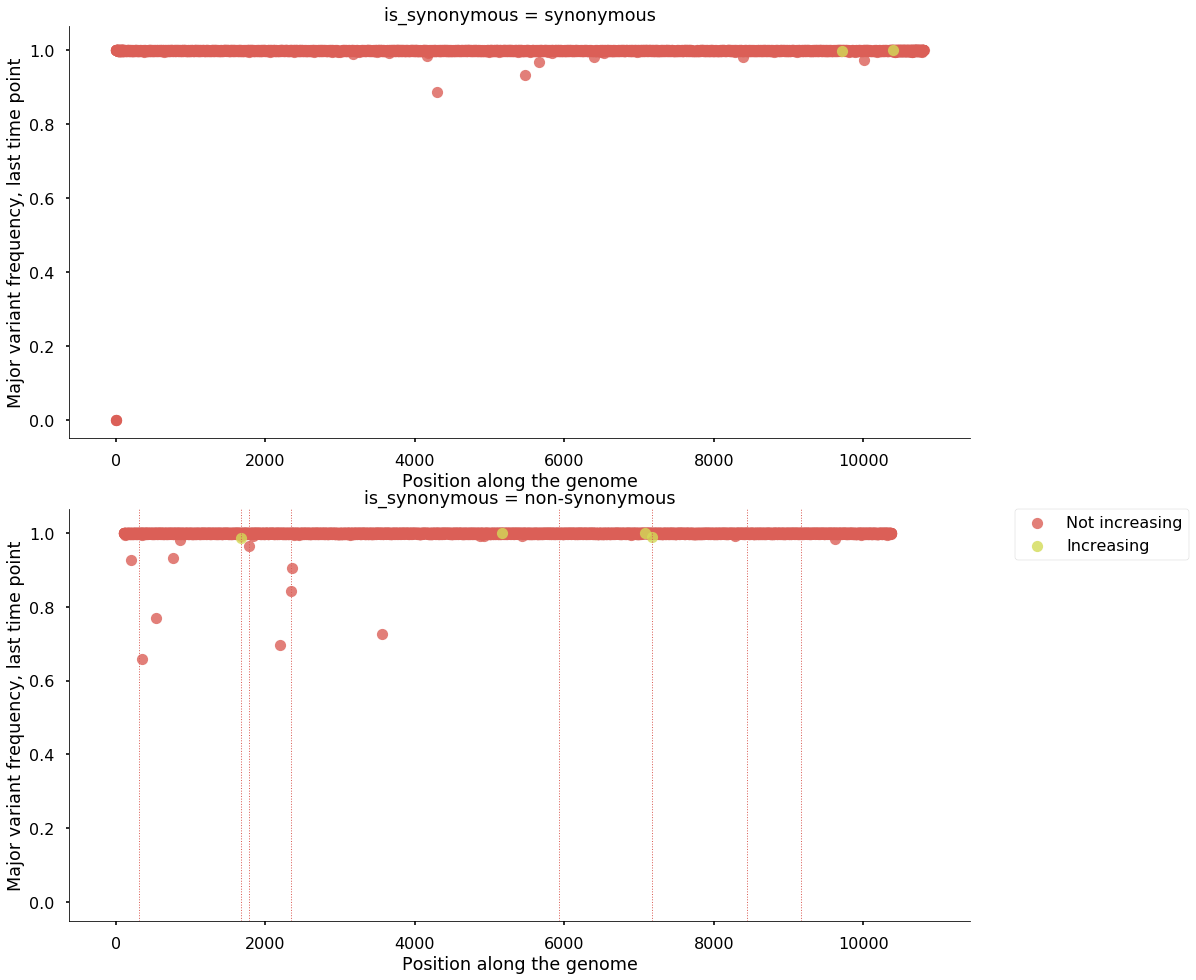

In [24]:
plot_increasing_positions(increasing_E, DD24_E)

In [25]:

write_increasing_positions(increasing_E, tables_E, ["DD3_E", "DD6_E", "DD9_E", "DD12_E", "DD18_E", "DD24_E"], "increasing_E.csv")


36


## Plotting only positions that consistently rise in frequency, treatment, replicate A

In [27]:
increasing_TA = get_increasing_variants(tables_TA)
print("There are "+str(len(increasing_TA))+" positions that rise in frequency.")
print("Those are:")
print(increasing_TA.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


There are 6 positions that rise in frequency.
Those are:
dict_keys([1785, 2428, 3709, 4606, 5332, 8519])


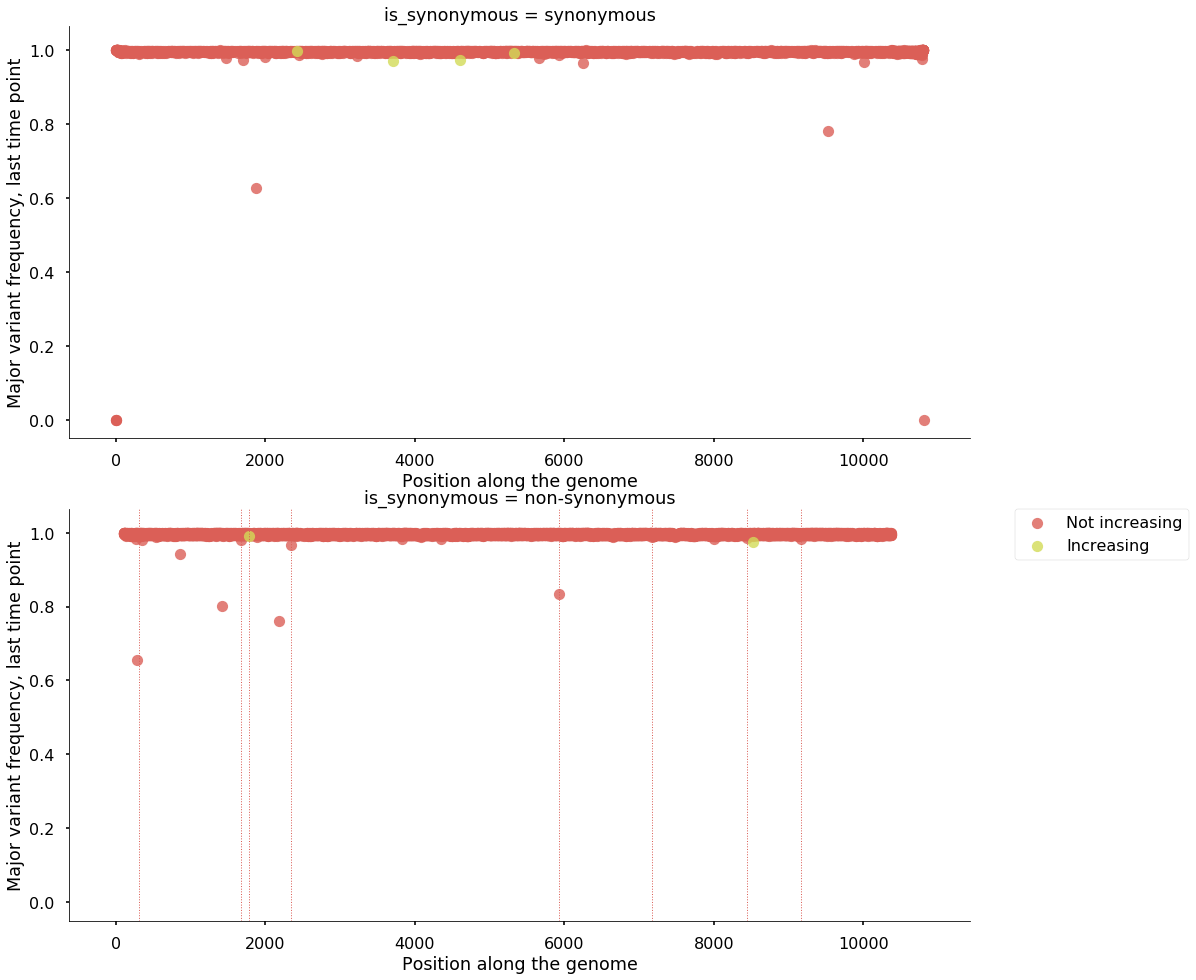

In [28]:
plot_increasing_positions(increasing_TA, TD51_A)

In [29]:
write_increasing_positions(increasing_TA, tables_TA, [ "TD9_A", "TD12_A", "TD18_A", "TD24_A", "TD51_A"], "increasing_TA.csv")


30


## Plotting only positions that consistently rise in frequency, treatment, replicate D

In [30]:
increasing_TD = get_increasing_variants(tables_TD)
print("There are "+str(len(increasing_TD))+" positions that rise in frequency.")
print("Those are:")
print(increasing_TD.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


There are 1173 positions that rise in frequency.
Those are:
dict_keys([68, 96, 109, 228, 249, 269, 271, 283, 288, 290, 291, 294, 303, 308, 311, 313, 317, 324, 325, 326, 330, 335, 339, 347, 349, 352, 366, 376, 377, 386, 408, 419, 426, 427, 442, 453, 454, 463, 477, 489, 490, 505, 541, 542, 556, 578, 592, 598, 615, 683, 688, 722, 723, 727, 744, 771, 782, 790, 798, 825, 840, 859, 860, 929, 930, 943, 959, 974, 977, 983, 1001, 1014, 1015, 1016, 1018, 1021, 1022, 1023, 1026, 1027, 1028, 1030, 1031, 1032, 1033, 1034, 1038, 1039, 1041, 1042, 1043, 1045, 1047, 1048, 1049, 1050, 1052, 1053, 1055, 1056, 1057, 1060, 1061, 1063, 1064, 1065, 1067, 1068, 1069, 1070, 1071, 1075, 1076, 1080, 1082, 1083, 1085, 1086, 1087, 1088, 1089, 1091, 1093, 1095, 1096, 1097, 1098, 1100, 1101, 1102, 1104, 1105, 1107, 1109, 1111, 1113, 1114, 1116, 1119, 1121, 1122, 1152, 1158, 1165, 1174, 1176, 1180, 1190, 1194, 1202, 1205, 1206, 1207, 1208, 1210, 1212, 1213, 1216, 1217, 1218, 1221, 1224, 1226, 1227, 1228, 1229, 1230,

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


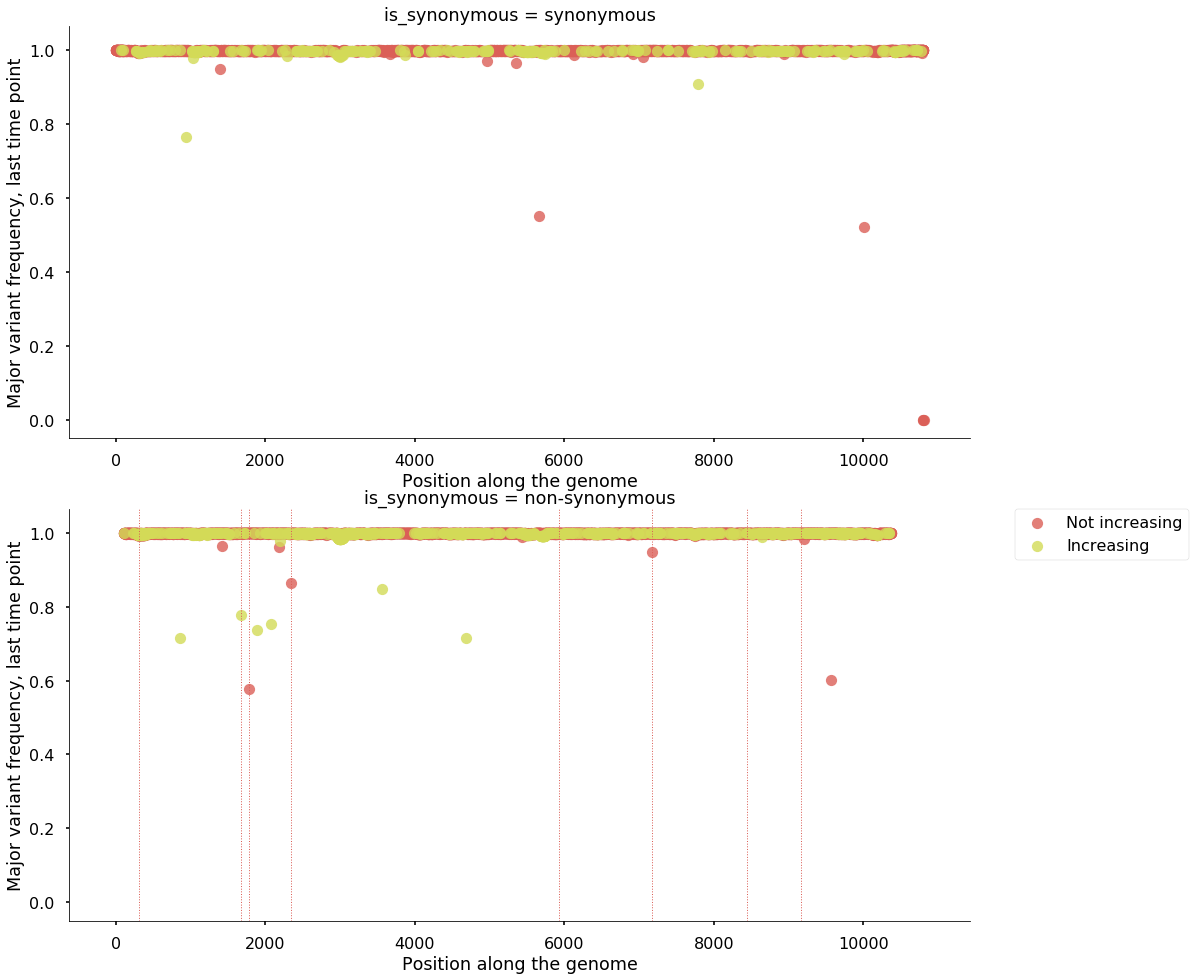

In [32]:
plot_increasing_positions(increasing_TD, TD24_D)

In [33]:
write_increasing_positions(increasing_TD, tables_TD, [ "TD9_D", "TD12_D", "TD18_D", "TD24_D"], "increasing_TD.csv")


4692


## Plotting only positions that consistently rise in frequency, treatment, replicate E

In [34]:
increasing_TE = get_increasing_variants(tables_TE)
print("There are "+str(len(increasing_TE))+" positions that rise in frequency.")
print("Those are:")
print(increasing_TE.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


There are 446 positions that rise in frequency.
Those are:
dict_keys([33, 34, 39, 40, 50, 60, 63, 64, 76, 90, 96, 112, 113, 185, 188, 214, 239, 264, 269, 271, 309, 338, 340, 362, 366, 390, 401, 458, 503, 505, 518, 573, 655, 670, 689, 705, 714, 730, 733, 739, 747, 752, 773, 778, 779, 787, 810, 823, 824, 827, 848, 859, 881, 896, 927, 928, 947, 986, 1090, 1140, 1218, 1253, 1280, 1283, 1310, 1317, 1331, 1332, 1348, 1384, 1395, 1427, 1430, 1438, 1442, 1464, 1530, 1569, 1576, 1578, 1580, 1582, 1593, 1594, 1596, 1597, 1615, 1713, 1768, 1773, 1775, 1785, 1786, 1810, 1827, 1828, 1841, 1880, 1935, 1949, 1968, 1971, 1982, 1987, 2008, 2018, 2027, 2046, 2052, 2074, 2085, 2141, 2189, 2200, 2211, 2232, 2242, 2252, 2267, 2287, 2326, 2340, 2360, 2384, 2398, 2490, 2508, 2525, 2564, 2636, 2638, 2651, 2679, 2699, 2703, 2704, 2733, 2757, 2777, 2787, 2791, 2810, 2811, 2929, 3051, 3094, 3216, 3249, 3253, 3267, 3313, 3321, 3324, 3335, 3337, 3439, 3452, 3480, 3505, 3519, 3523, 3525, 3544, 3555, 3561, 3570, 357

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


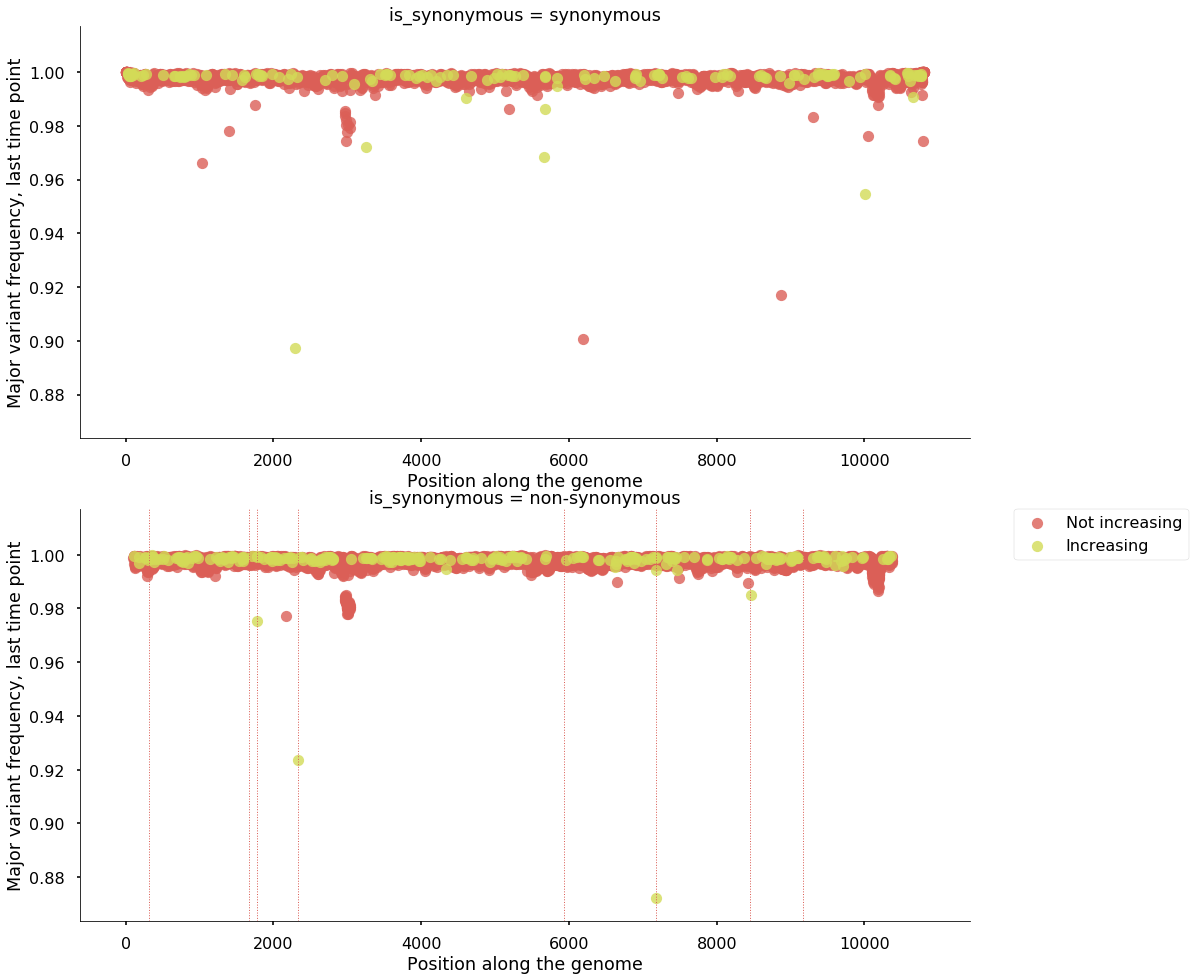

In [35]:
plot_increasing_positions(increasing_TE, TD24_E)

In [36]:

write_increasing_positions(increasing_TE, tables_TE, [ "TD9_E", "TD12_E", "TD18_E", "TD24_E"], "increasing_TE.csv")


1784
